# Тут надо добавить

Контекст, краткое описание задачи и список шагов/тем/подтем, в идеале learning outcomes

План примерно такой:

- Подготовка данных
- Ранжирование фичей
  - По корреляции с таргетом
  - По feature importance полной модели
- Отбор с помощью Лассо
- Жадный перебор
  - Forward construction
  - Backward elimination
- Weight of Evidence and Information Value

#Get data from kaggle:

https://www.kaggle.com/imakash3011/customer-personality-analysis

#Links

1. https://machinelearningmastery.com/feature-selection-machine-learning-python/
2. https://www.datacamp.com/community/tutorials/feature-selection-python
3. https://sundarstyles89.medium.com/weight-of-evidence-and-information-value-using-python-6f05072e83eb



#Import libs

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import scipy
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.metrics import balanced_accuracy_score, f1_score

!pip install catboost

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

from google.colab import drive 
drive.mount('/content/gdrive')

     |████████████████████████████████| 76.1 MB 1.3 MB/s 
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Prep data

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/marketing_campaign.csv', sep='\t')
data = data.set_index('ID')

data = data.dropna()
data = data.drop(columns=['Z_Revenue', 'Z_CostContact'])

data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
ID,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


## Simple feature engineering

- Сount the number of days after registration
- One-hot encoding for Education and Marital Status

In [ ]:
import datetime
from datetime import date

data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
now_date = datetime.date.today()
now_date = pd.to_datetime(now_date)
data['Days_reg'] = now_date - data.Dt_Customer

data['Days_reg'] = pd.to_numeric(data['Days_reg'].dt.days, downcast='integer')

data = data.drop(columns=['Dt_Customer'])

idx = data['Marital_Status'].isin(['Widow', 'Alone', 'YOLO', 'Absurd'])
data.loc[idx, 'Marital_Status'] = 'Other'

data = pd.get_dummies(data, columns=['Education', 'Marital_Status'], drop_first=True)

data.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_reg,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Other,Marital_Status_Single,Marital_Status_Together
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,1957,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,3584,0,1,0,0,0,0,1,0
2174,1954,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,2738,0,1,0,0,0,0,1,0
4141,1965,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,3085,0,1,0,0,0,0,0,1
6182,1984,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,2678,0,1,0,0,0,0,0,1
5324,1981,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,2934,0,0,0,1,1,0,0,0


## Make features and target sets

In [ ]:
x = data.copy()

x = x.drop(columns=['Response'])

y = data['Response']

print(x.shape, y.shape)

x.head()

## Proportion 1 and 0

In [ ]:
y.value_counts(normalize=True)

0    0.849729
1    0.150271
Name: Response, dtype: float64

## Set up for further experiments

In [ ]:
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics 

scor_met = 'roc_auc'

cv_5 = StratifiedKFold( 
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

# Baseline model


In [ ]:
random_forest = RandomForestClassifier(
    n_estimators=50, 

    max_depth=8,
    min_samples_leaf=50,

    random_state=42,
    n_jobs=-1
)

random_forest.fit(x, y)

scores = cross_val_score(random_forest, x, y, cv=cv_5, scoring=scor_met)

print('Scores on 5 folds: {}'.format(scores))
print('')
print("Average accuracy is %0.4f with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Scores on 5 folds: [0.84120512 0.81690616 0.88532074 0.88475605 0.86821799]

Average accuracy is 0.8593 with a standard deviation of 0.03


## Features amount

In [ ]:
features_amnt_total = len(x.columns)
features_amnt_total

31

## Put result in table

In [ ]:
result = pd.DataFrame.from_dict([{
    'Method': 'All features',
    'Accuracy': scores.mean(),
    'Features amount': features_amnt_total
}])

result

,Method,Accuracy,Features amount
0,All features,0.859281,31


# Correlation matrix

The correlation matrix is one way to rank features by "importance", but not the only one.

## Create heatmap

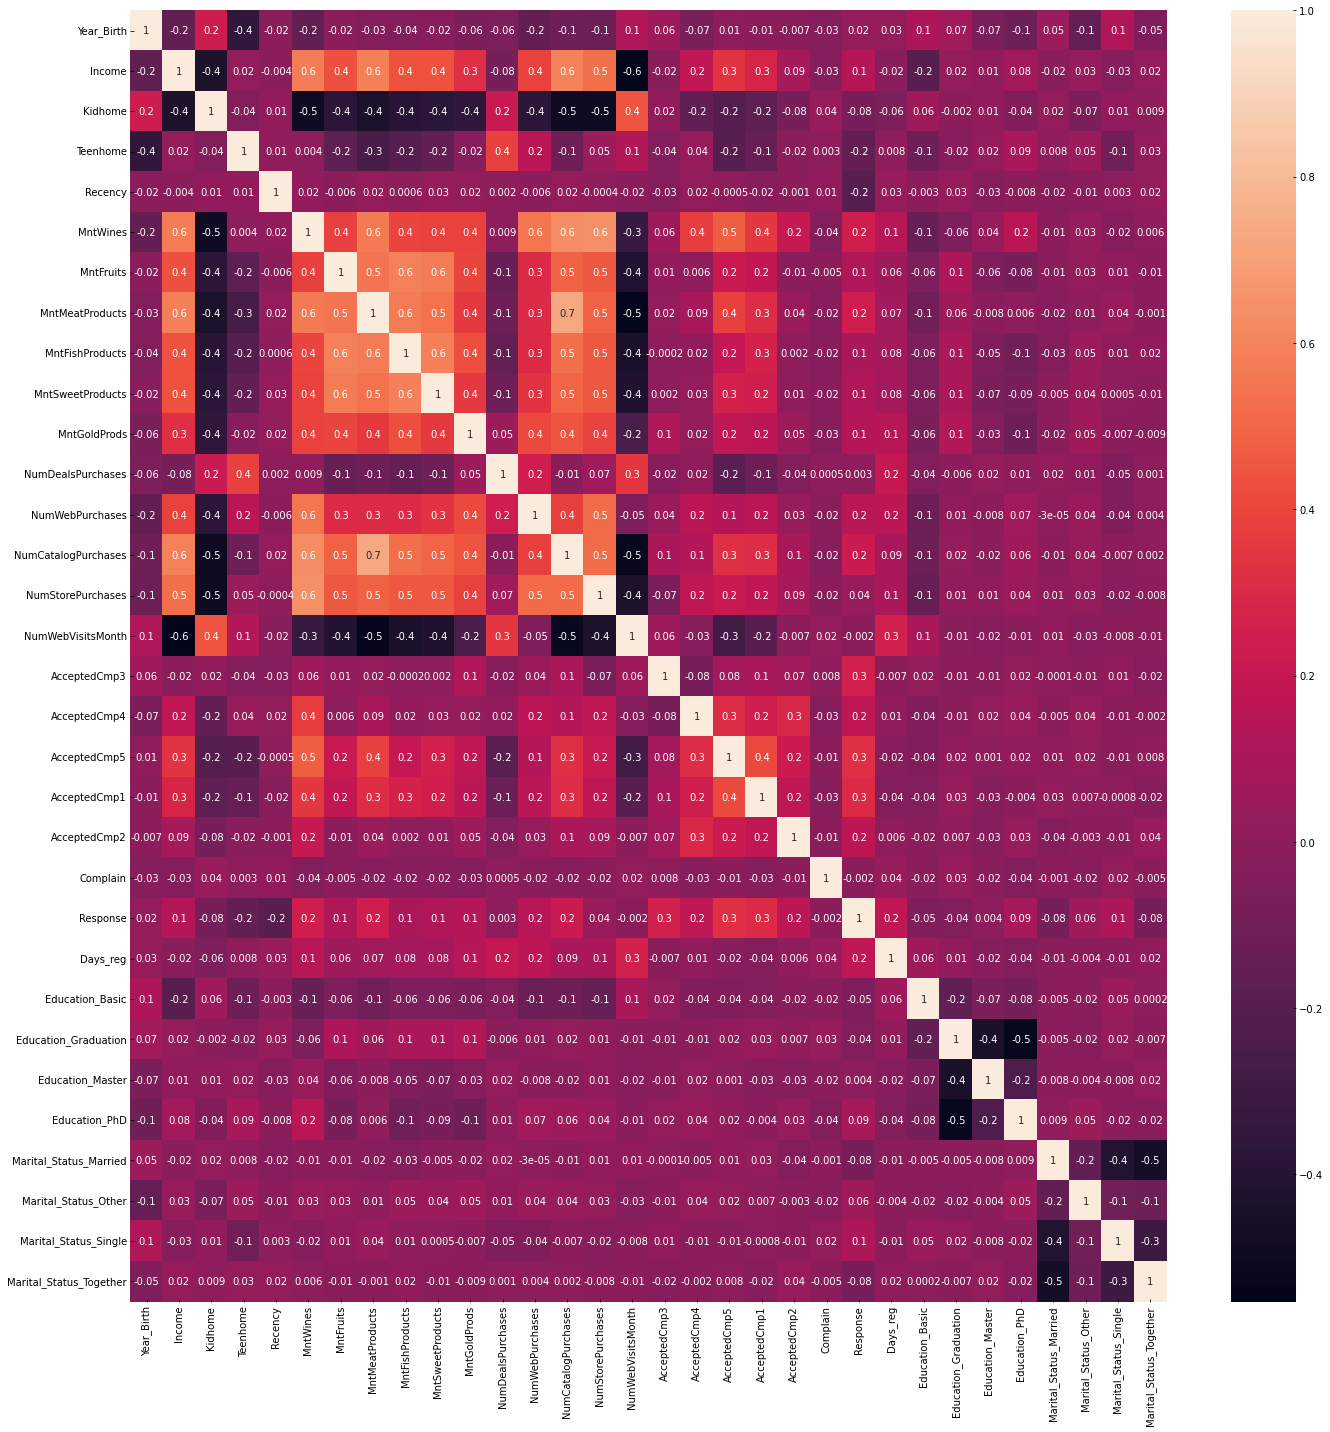

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, fmt='.1g')
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

## Sort correlation

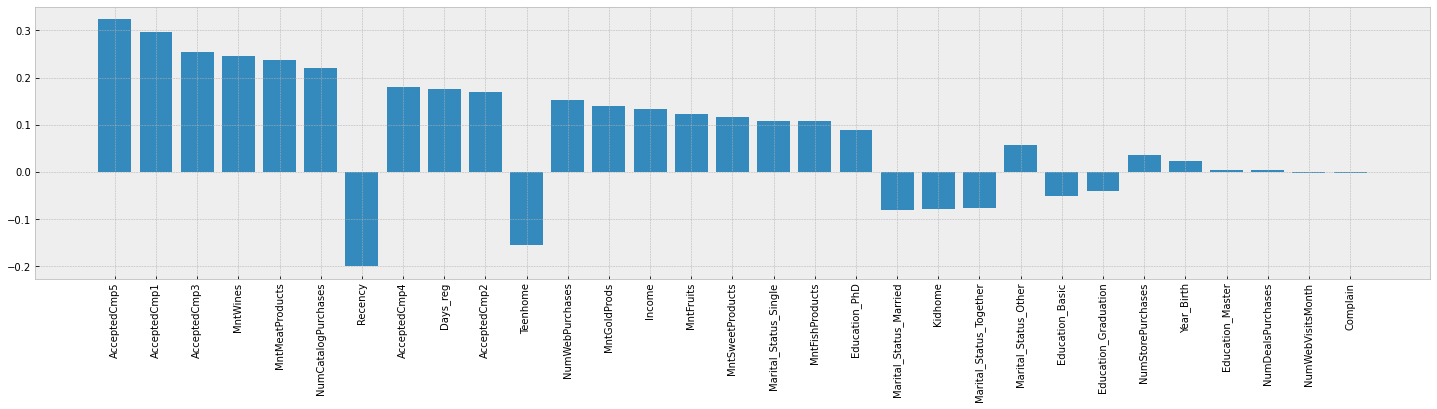

In [ ]:
correlation = data.corr()
correlation = correlation['Response']
correlation = correlation.drop('Response')
sort_index = np.argsort(abs(correlation))[::-1]
labels = np.array(correlation.index)[sort_index]

plt.figure(figsize=(25, 5))
plt.bar(range(len(correlation)), correlation[sort_index], tick_label=labels)
plt.xticks(rotation = 90)
plt.show()

## Learn model



In [ ]:
feature_selection_by_correlation = []

for i in range(1, len(labels)+1):

  selected_features = labels[:i]
  x_top_features = data[selected_features].copy()
    
  scores = cross_val_score(random_forest, x_top_features, y, cv=cv_5, scoring=scor_met).mean()

  feature_selection_by_correlation.append((scores, len(selected_features)))

ser_fs_by_corr = pd.DataFrame(
    feature_selection_by_correlation, 
    index=range(1, len(labels)+1)
)

TypeError: ignored

In [ ]:
feature_selection_by_correlation[0][1]

1

In [ ]:
ser_fs_by_corr.columns= ('Scores','Number  of features')

In [ ]:
df_fs_by_corr = pd.DataFrame(feature_selection_by_correlation, columns=['Scores', 'Number of features'])

#.sort_values(by='Scores', ascending=False)[:10]
#процент изменения скора
df_fs_by_corr['percent_change'] = df_fs_by_corr['Scores'].pct_change().abs()
#считаем процент отклонения
df_fs_by_corr['dev_max'] =(df_fs_by_corr['Scores'].max()-df_fs_by_corr['Scores'])*100
#выбираем порог в 1 процент
df_fs_by_corr[df_fs_by_corr['dev_max'] >= 1].sort_values(by='Scores', ascending=False)

,Scores,Number of features,percent_change,dev_max
16,0.852911,17,0.001985,1.002513
14,0.852769,15,0.000189,1.016652
13,0.852609,14,0.003066,1.032728
15,0.851221,16,0.001815,1.171466
10,0.850206,11,0.003222,1.272947
12,0.850003,13,0.000758,1.293315
11,0.849359,12,0.000996,1.357669
9,0.847476,10,0.002056,1.546003
8,0.845737,9,0.028725,1.719925
7,0.822121,8,0.003099,4.081461


Analyzing the graph, you can see that for the normal quality of the model, ***10 features*** out of 31 are enough. With a further increase in the number of features, we get a slight increase in the quality of the model.

Тут надо написать какие-то выводы, мол для нормального качества достаточно 10 фичей из 30, далее прирост незначительный

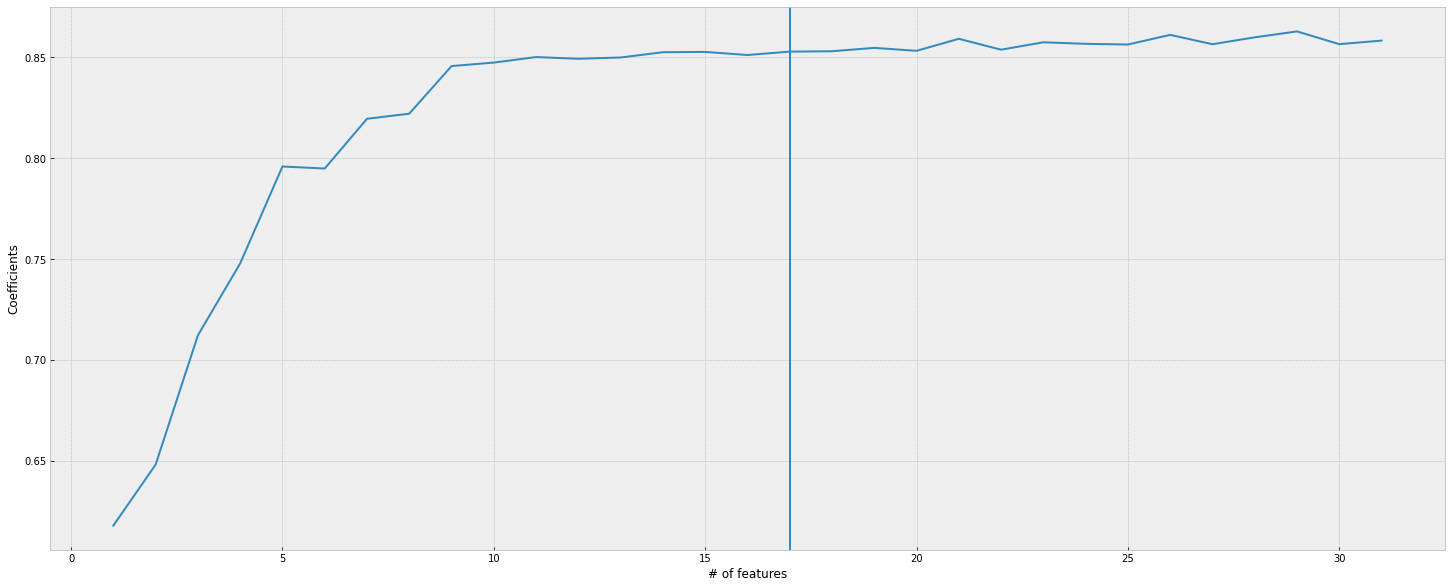

In [ ]:
plt.figure(figsize=(25,10))

plt.plot(ser_fs_by_corr['Scores'])
plt.axvline(x=17)

plt.xlabel('# of features')
plt.ylabel('Coefficients')

plt.show()

# Feature importance

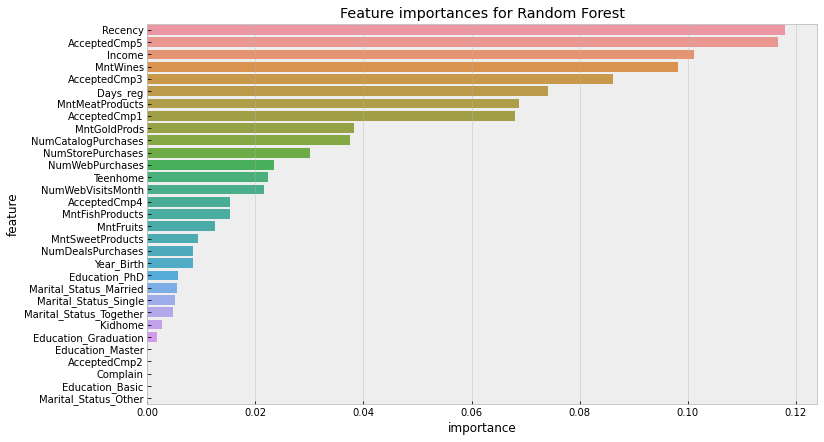

In [ ]:
import seaborn as sns

feature_importances = zip(x.columns, random_forest.feature_importances_)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
feature_importances = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

plt.figure(figsize=(12,7))
plt.title('Feature importances for Random Forest')
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.show()

In [ ]:
feature_selection_by_feature_importance = []

for i in range(1, len(labels)+1):

  selected_features = feature_importances['feature'].iloc[:i].tolist()
  x_top_features = data[selected_features].copy()
    
  scores = cross_val_score(random_forest, x_top_features, y, cv=cv_5, scoring=scor_met).mean()

  feature_selection_by_feature_importance.append(scores)

feature_selection_by_feature_importance = pd.Series(
    feature_selection_by_feature_importance, 
    index=range(1, len(labels)+1)
)

Analyzing the graph, we can come to the conclusion that to achieve the quality of the model at the same level as in the previous method, ***8 features*** are enough (using the correlation matrix, ***10 features***). A further increase in the number of features gives a slight increase in the quality of the model.

Тоже какие-то выводы + надо сравнить с предыдущим графиком (тут при выборе 8-9 фичей качество такое же, как на предыдущем с 10)

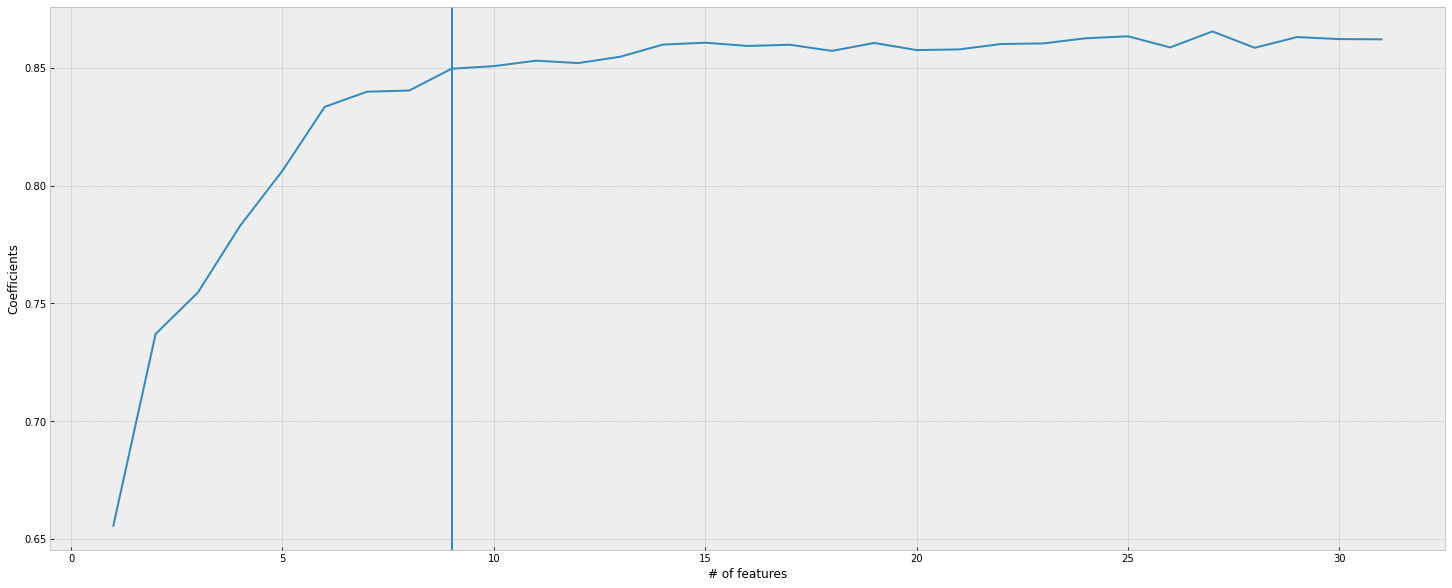

In [ ]:
plt.figure(figsize=(25,10))

plt.plot(feature_selection_by_feature_importance)
plt.axvline(x=9)

plt.xlabel('# of features')
plt.ylabel('Coefficients')

plt.show()

# Lasso

https://stats.stackexchange.com/questions/112737/what-is-the-meaning-of-regularization-path-in-lasso-or-related-sparsity-problems

https://hastie.su.domains/TALKS/nips2005.pdf

https://medium.com/analytics-vidhya/regularization-path-using-lasso-regression-c450eea9321e

## Make features and target

In [ ]:
for alpha in alphas:
  
  alphas_lasso, coefs_lasso, _ = lasso_path(x, y, alphas=alphas)

  coefs = pd.DataFrame(coefs_lasso.T, columns=x.columns)



In [ ]:
from sklearn import linear_model

clf = linear_model.LogisticRegression(C=2, penalty='l1', solver = 'liblinear', fit_intercept=True)

clf.fit(x, y)

print(clf.coef_)

print(pd.DataFrame(clf.coef_[0], index = x.columns))



[[-6.16149993e-03 -1.81471491e-06  3.09555141e-01 -9.35799531e-01
  -3.09138053e-02 -2.33335667e-04  2.86235940e-03  2.21817165e-03
  -1.57775085e-03  8.85649447e-04  3.15044182e-03  9.15531474e-02
   9.46549765e-02  5.39002924e-02 -1.54833686e-01  1.16241797e-01
   1.96769844e+00  1.22381404e+00  1.75580784e+00  1.47109881e+00
   1.49004520e+00  0.00000000e+00  3.25992002e-03 -1.05831066e+00
   2.86736039e-01  6.63662455e-01  1.26805591e+00 -1.26243026e+00
   5.21318897e-04  2.61993002e-02 -1.25306270e+00]]
                                0
Year_Birth              -0.006161
Income                  -0.000002
Kidhome                  0.309555
Teenhome                -0.935800
Recency                 -0.030914
MntWines                -0.000233
MntFruits                0.002862
MntMeatProducts          0.002218
MntFishProducts         -0.001578
MntSweetProducts         0.000886
MntGoldProds             0.003150
NumDealsPurchases        0.091553
NumWebPurchases          0.094655
NumCatalog

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path

alphas = np.logspace(-7, 0, 50)

alphas_lasso, coefs_lasso, _ = lasso_path(x, y, alphas=alphas)

coefs = pd.DataFrame(coefs_lasso.T, columns=x.columns)

coefs.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Days_reg,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Other,Marital_Status_Single,Marital_Status_Together
0,-0.000176,-8.279934e-07,0.0,-0.0,-0.001429,0.000174,-0.0,0.000254,-0.000000,-0.0,0.000000,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000165,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0
1,-0.000191,-8.580292e-07,0.0,-0.0,-0.001761,0.000174,-0.0,0.000262,-0.000000,-0.0,0.000000,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000180,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0
2,-0.000203,-8.481817e-07,0.0,-0.0,-0.002002,0.000175,-0.0,0.000279,-0.000104,-0.0,0.000000,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000191,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0
3,-0.000211,-8.416222e-07,0.0,-0.0,-0.002176,0.000175,-0.0,0.000293,-0.000200,-0.0,0.000035,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000198,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0
4,-0.000216,-8.414226e-07,0.0,-0.0,-0.002302,0.000173,-0.0,0.000302,-0.000280,-0.0,0.000098,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000203,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0


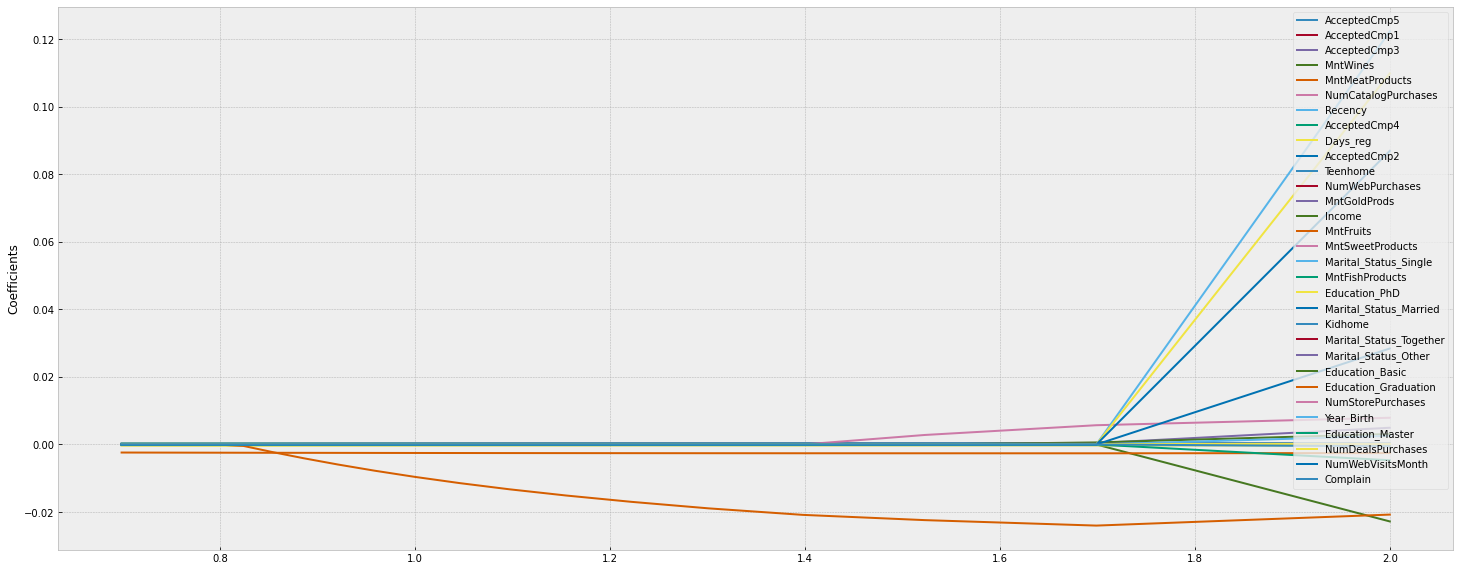

In [ ]:
neg_log_alphas_lasso = -np.log10(alphas_lasso)

plt.figure(figsize=(25,10))

plt.plot(neg_log_alphas_lasso, coefs)

plt.ylabel('Coefficients')
plt.legend(labels)

plt.show()

# Forward feature construction

## Find best feature

In [ ]:
X = data.copy()
X.drop('Response', axis='columns', inplace=True)

y = data['Response']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
X_train

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Days_reg,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Married,Marital_Status_Other,Marital_Status_Single,Marital_Status_Together
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7516,1983,30096.0,1,0,30,5,3,11,12,5,9,1,2,0,3,6,0,0,0,0,0,0,2811,0,1,0,0,1,0,0,0
3571,1961,63342.0,0,1,48,918,21,118,13,10,21,3,8,3,5,6,0,1,0,0,0,0,3394,0,0,0,1,0,0,0,1
7532,1980,43586.0,0,1,26,99,2,11,4,0,16,3,3,0,4,8,0,0,0,0,0,0,3441,0,1,0,0,1,0,0,0
1142,1953,55707.0,0,1,91,208,7,82,30,66,35,2,3,2,9,3,0,0,0,0,0,0,2962,0,0,0,1,1,0,0,0
5491,1951,47352.0,0,1,70,172,12,112,8,0,15,4,6,1,5,7,0,0,0,0,0,0,3010,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3381,1953,54348.0,1,1,51,70,0,16,0,0,4,2,2,0,4,6,0,0,0,0,0,0,2735,0,0,1,0,1,0,0,0
8175,1992,34935.0,0,0,71,34,4,66,3,10,20,1,2,1,4,7,0,0,0,0,0,0,3146,0,1,0,0,1,0,0,0
9064,1982,69109.0,0,0,10,823,25,459,124,29,95,1,6,6,7,4,0,0,1,0,0,0,3429,0,1,0,0,1,0,0,0


In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(auto_class_weights='Balanced', n_estimators=100, verbose=0, random_state=42)

In [ ]:
scores = []
best_features = []
col = []
for i in range(1, len(X_train.columns)+1):
  initial_features = X_train.columns.tolist()
  fs_by_forward = []
  remaining_features = list(set(initial_features)-set(best_features))



  for col in remaining_features:
    model.fit(X_train[best_features + [col]], y_train)
    y_pred = model.predict(X_test[best_features + [col]])
    score = f1_score(y_test, y_pred)

    fs_by_forward.append((score, col))
  
  name_of_best_feature = pd.DataFrame(fs_by_forward, columns=('scores', 'features')).sort_values(by='scores', ascending=False).iloc[0,1]
 
  f1 = pd.DataFrame(fs_by_forward, columns=('scores', 'features')).sort_values(by='scores', ascending=False).iloc[0,0]
  print(f'number iteration {i}')
  print(pd.DataFrame(fs_by_forward, columns=('scores', 'features')).sort_values(by='scores', ascending=False).head(5))
  # if f1>scores[len(scores)-1]:
  #   print(f'prev value {scores[len(scores)-1]}')
  #   scores.append(f1)
  #   number_of_features.append(X_test[best_features + [column]].columns.tolist())
  #   print(f'last value {scores[len(scores)-1]}')
  scores.append((f1, i, best_features + [name_of_best_feature]))
  best_features.append(name_of_best_feature)
  



Custom logger is already specified. Specify more than one logger at same time is not thread safe.

number iteration 1
      scores           features
11  0.382716       AcceptedCmp1
13  0.379085       AcceptedCmp5
22  0.376900           MntWines
24  0.362245    MntMeatProducts
4   0.335404  NumStorePurchases
number iteration 2
      scores      features
22  0.447761  AcceptedCmp3
12  0.441989  AcceptedCmp5
1   0.434783       Recency
17  0.428115      Days_reg
21  0.414035      MntWines
number iteration 3
      scores           features
12  0.493151       AcceptedCmp5
21  0.473282           MntWines
24  0.471154  NumDealsPurchases
1   0.464286            Recency
14  0.458537       AcceptedCmp2
number iteration 4
      scores                 features
23  0.513274        NumDealsPurchases
19  0.502326  Marital_Status_Together
13  0.502242             AcceptedCmp2
0   0.495413                 Teenhome
17  0.495413                  Kidhome
number iteration 5
      scores                 features
26  0.524590        NumWebVisitsMonth
19  0.522523  Marital_Status_Together
13  0.521739     

In [ ]:
scores 

[(0.382716049382716, 1, ['AcceptedCmp1']),
 (0.44776119402985076, 2, ['AcceptedCmp1', 'AcceptedCmp3']),
 (0.4931506849315069, 3, ['AcceptedCmp1', 'AcceptedCmp3', 'AcceptedCmp5']),
 (0.5132743362831858,
  4,
  ['AcceptedCmp1', 'AcceptedCmp3', 'AcceptedCmp5', 'NumDealsPurchases']),
 (0.5245901639344261,
  5,
  ['AcceptedCmp1',
   'AcceptedCmp3',
   'AcceptedCmp5',
   'NumDealsPurchases',
   'NumWebVisitsMonth']),
 (0.550185873605948,
  6,
  ['AcceptedCmp1',
   'AcceptedCmp3',
   'AcceptedCmp5',
   'NumDealsPurchases',
   'NumWebVisitsMonth',
   'Marital_Status_Married']),
 (0.550185873605948,
  7,
  ['AcceptedCmp1',
   'AcceptedCmp3',
   'AcceptedCmp5',
   'NumDealsPurchases',
   'NumWebVisitsMonth',
   'Marital_Status_Married',
   'Education_Basic']),
 (0.5853658536585366,
  8,
  ['AcceptedCmp1',
   'AcceptedCmp3',
   'AcceptedCmp5',
   'NumDealsPurchases',
   'NumWebVisitsMonth',
   'Marital_Status_Married',
   'Education_Basic',
   'Recency']),
 (0.5771812080536913,
  9,
  ['AcceptedC

In [ ]:
pd.DataFrame(scores).sort_values(by=0, ascending=False)

,0,1,2
23,0.647773,24,"[AcceptedCmp1, AcceptedCmp3, AcceptedCmp5, Num..."
18,0.642336,19,"[AcceptedCmp1, AcceptedCmp3, AcceptedCmp5, Num..."
21,0.641667,22,"[AcceptedCmp1, AcceptedCmp3, AcceptedCmp5, Num..."
20,0.636364,21,"[AcceptedCmp1, AcceptedCmp3, AcceptedCmp5, Num..."
15,0.635714,16,"[AcceptedCmp1, AcceptedCmp3, AcceptedCmp5, Num..."
25,0.634783,26,"[AcceptedCmp1, AcceptedCmp3, AcceptedCmp5, Num..."
19,0.633745,20,"[AcceptedCmp1, AcceptedCmp3, AcceptedCmp5, Num..."
17,0.633094,18,"[AcceptedCmp1, AcceptedCmp3, AcceptedCmp5, Num..."
24,0.630252,25,"[AcceptedCmp1, AcceptedCmp3, AcceptedCmp5, Num..."
13,0.625000,14,"[AcceptedCmp1, AcceptedCmp3, AcceptedCmp5, Num..."


In [ ]:
scores[:-1]

[0, 0.38297872340425526, 0.38297872340425526]

In [ ]:
X_train[best_features + [column]]

,AcceptedCmp1,Kidhome,Teenhome,AcceptedCmp5,NumDealsPurchases,Education_Basic,Recency,Marital_Status_Married,Income,MntWines
ID,,,,,,,,,,
7516,0,1,0,0,1,0,30,1,30096.0,5
3571,0,0,1,0,3,0,48,0,63342.0,918
7532,0,0,1,0,3,0,26,1,43586.0,99
1142,0,0,1,0,2,0,91,1,55707.0,208
5491,0,0,1,0,4,0,70,0,47352.0,172
...,...,...,...,...,...,...,...,...,...,...
3381,0,1,1,0,2,0,51,1,54348.0,70
8175,0,0,0,0,1,0,71,1,34935.0,34
9064,0,0,0,1,1,0,10,1,69109.0,823


In [ ]:
pd.DataFrame(fs_by_forward, columns=('scores', 'features')).sort_values(by='scores', ascending=False).iloc[0,1]

'AcceptedCmp1'

# Поставить везде кэтбуст, везде ф1 метрику

In [ ]:
def forward_selection(data, target, significance_level=0.05):
    initial_features = X_train.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

# Weight of evidence and information value

In [ ]:
def calc_iv(df, feature, target, pr=0):

    lst = []

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], df[(df[feature] == val) & (df[target] == 1)].count()[feature]])

    table = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])
    table = table[table['Bad'] > 0]

    table['Share'] = table['All'] / table['All'].sum()
    table['Bad Rate'] = table['Bad'] / table['All']
    table['Distribution Good'] = (table['All'] - table['Bad']) / (table['All'].sum() - table['Bad'].sum())
    table['Distribution Bad'] = table['Bad'] / table['Bad'].sum()
    table['WoE'] = np.log(table['Distribution Good'] / table['Distribution Bad'])
    table['IV'] = (table['WoE'] * (table['Distribution Good'] - table['Distribution Bad'])).sum()

    table = table.sort_values(by=['Variable', 'Value'], ascending=True)
    if pr == 1:
      print(table)
      
    return table    

In [ ]:
for i in range(1, len(x.columns)):
  calc_iv(data, x.columns[i], 'Response', pr=1)

# Summary

In [ ]:
result = pd.DataFrame(result, columns=['Method', 'Accuracy', 'Features amount'])
result.head()

,Method,Accuracy,Features amount
0,All features,0.859281,31
